In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

In [41]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [42]:
data_water=parse.parse('SMHIdata/cloudrm_water.dat')
data_clear=parse.parse('SMHIdata/cloudrm_clear.dat')
data_ice=parse.parse('SMHIdata/cloudrm_ice.dat')
data_mixed=parse.parse('SMHIdata/cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()
df_truth=df_truth.reset_index(drop=True)

In [43]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

y_labels=['Clear_B11']


##Split data##
X=df_truth[X_labels]
y=df_truth[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

np.random.seed(313)
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X.to_numpy(),axis=0)*0.03

In [44]:
quantiles=np.array([0.1,0.5,0.9])
no_nodes=64
est= np.where(quantiles==0.5)[0].item()

sequence= lambda: nn.Sequential(
    nn.Linear(len(X_labels),no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

In [45]:
val_size=0.1
batch_size=500 

lr_s=[0.003]

num_models=5 #Set number of ensambles
batch_size=500
nepochs=1000
lr=0.003
noise_ratio = 0.03
early_break=True

looped_metric="Loop_learning_rate"
main_filepath='pytorch_models/'+looped_metric

model_metrics=pd.DataFrame(columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
for lr in lr_s:

    
    models=[QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]
    preds_total=[]
    for i,model in enumerate(models): 

        validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X['Cloud_B02'])*val_size)))
        train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]       

        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break)
        
        filepath=main_filepath+'/'+str(lr)+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

        preds = model.predict(X_test.to_numpy())
        if i==0:
            preds_total=preds
        else:
            preds_total=preds_total+preds

        mse=mean_squared_error(y_test.to_numpy(),preds[:,:,est])
        psnr=QuantileNetwork.PSNR(y_test,preds[:,:,est])
        r2=r2_score(y_test.to_numpy(),preds[:,:,est])
        mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds,quantiles)
        quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)

        tmp_metrics=pd.DataFrame(data=[[False,i,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
        model_metrics=pd.concat([model_metrics,tmp_metrics])
    
    preds_total=preds_total/num_models

    mse=mean_squared_error(y_test.to_numpy(),preds_total[:,:,est])
    psnr=QuantileNetwork.PSNR(y_test,preds_total[:,:,est])
    r2=r2_score(y_test.to_numpy(),preds_total[:,:,est])
    mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds_total,quantiles)
    quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds_total)

    tmp_metrics=pd.DataFrame(data=[[True,np.nan,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
    model_metrics=pd.concat([model_metrics,tmp_metrics])


X_test.to_csv(main_filepath+'/xtest.csv',index=False)
y_test.to_csv(main_filepath+'/ytest.csv',index=False)

model_metrics=model_metrics.reset_index(drop=True)
model_metrics.to_csv(main_filepath+'/model_metrics.csv',index=False)

Epoch 391


Batch number: 100%|██████████| 320/320 [00:00<00:00, 378.80it/s]

Training loss [0.18030198] Validation loss [0.18619734]
Epoch 392



Batch number: 100%|██████████| 320/320 [00:00<00:00, 369.02it/s]

Training loss [0.18079653] Validation loss [0.18454245]
Epoch 393



Batch number: 100%|██████████| 320/320 [00:00<00:00, 377.02it/s]

Training loss [0.18046753] Validation loss [0.18372339]
Epoch 394



Batch number: 100%|██████████| 320/320 [00:00<00:00, 378.92it/s]

Training loss [0.18058732] Validation loss [0.18206125]
----New best validation loss---- [0.18206125]
Epoch 395



Batch number: 100%|██████████| 320/320 [00:00<00:00, 369.88it/s]

Training loss [0.18082905] Validation loss [0.1839944]
Epoch 396



Batch number: 100%|██████████| 320/320 [00:00<00:00, 368.54it/s]

Training loss [0.18054615] Validation loss [0.18438633]
Epoch 397



Batch number: 100%|██████████| 320/320 [00:00<00:00, 367.55it/s]

Training loss [0.18069673] Validation loss [0.1830634]
Epoch 398



Batch number: 100%|██████████| 320/320 [00:00<00:00, 367.18it/s]

Training loss [0.18012272] Validation loss [0.18420883]
Epoch 399



Batch number: 100%|██████████| 320/320 [00:00<00:00, 366.91it/s]

Training loss [0.18067041] Validation loss [0.18418804]
Epoch 400



Batch number:   0%|          | 0/320 [00:00<?, ?it/s]

In [ ]:
model_metrics

,Ensemble_mean,Ensemble_index,Loop_learning_rate,MSE,PSNR,R2_score,Mean_Quantile_Loss,Quant_Rate,Quantiles
0,False,0,0.003,0.012088,23.800456,0.826117,0.049065,"[0.13435, 0.5774, 0.93415]","[0.1, 0.5, 0.9]"
1,False,1,0.003,0.011451,24.035318,0.835271,0.048616,"[0.1077, 0.53135, 0.9207]","[0.1, 0.5, 0.9]"
2,False,2,0.003,0.011521,24.009003,0.834270,0.048481,"[0.1008, 0.4878, 0.9023]","[0.1, 0.5, 0.9]"
3,False,3,0.003,0.011623,23.970805,0.832806,0.048685,"[0.1217, 0.53285, 0.90375]","[0.1, 0.5, 0.9]"
4,False,4,0.003,0.011533,24.004589,0.834101,0.048419,"[0.10545, 0.5291, 0.909]","[0.1, 0.5, 0.9]"
5,True,NaN,0.003,0.011169,24.143611,0.839328,0.047253,"[0.09945, 0.5282, 0.9292]","[0.1, 0.5, 0.9]"


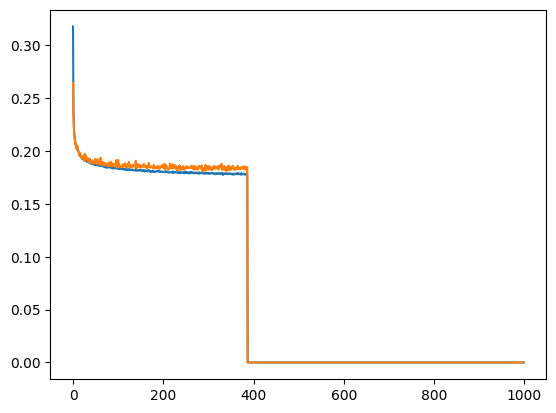

In [ ]:
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()

In [ ]:
MSE_col = np.mean((preds_total[:,:,est]-y_test.to_numpy())**2,axis=0)
print(MSE_col)

[0.01116923]


In [ ]:
error_percent = 100*np.divide(np.abs(preds_total[:,:,est]-y_test.to_numpy()),y_test.to_numpy())

err_perc_col = np.mean(error_percent,axis=0)

print(err_perc_col)

[14.17111061]


/tmp/ipykernel_11294/1500902760.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_bins[j] = err_bins[j] + errors[i]
/tmp/ipykernel_11294/1500902760.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  unc_bins[j] = unc_bins[j] + uncs[i]


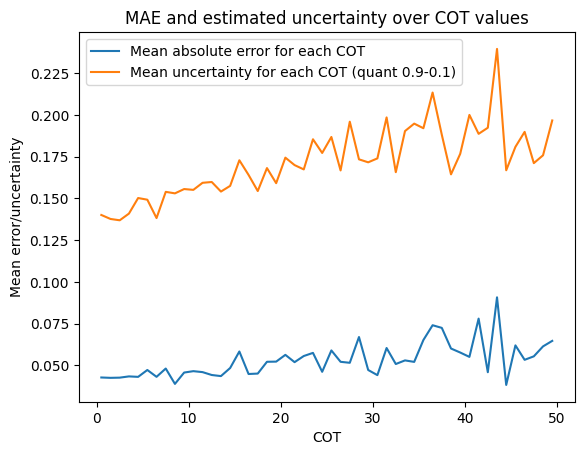

In [ ]:
#Find COTs of all test points
testindices=y_test.index
COTs=np.array(df_truth['COT'].iloc[testindices])

#find sorted numpy indices and sort COT array
COTidx=np.argsort(COTs)
COT_sorted = COTs[COTidx]

#sort numpy test and preds by COT
y_test_np_sort=np.array(y_test)[COTidx,:]
y_pred_sort=preds_total[COTidx,:,:]

#Find errors and uncs for band 11

errors = np.abs(y_test_np_sort[:,:]-y_pred_sort[:,:,est])
uncs = y_pred_sort[:,:,2]-y_pred_sort[:,:,0]

#sort errors and uncs into bins based on COT
COTedges=np.linspace(0,50,51)
err_bins = np.zeros(len(COTedges)-1)
unc_bins = np.zeros(len(COTedges)-1)
bin_freq = np.zeros(len(COTedges)-1)

for i in range(len(COT_sorted)):
    for j in range(len(COTedges)-1):   
        if COT_sorted[i] > COTedges[j] and COT_sorted[i] < COTedges[j+1]:
            err_bins[j] = err_bins[j] + errors[i]
            unc_bins[j] = unc_bins[j] + uncs[i]
            bin_freq[j] = bin_freq[j] + 1
            break

#Find mean errs and uncs in each bin
err_mean_bins = err_bins/bin_freq
unc_mean_bins = unc_bins/bin_freq

x=COTedges[:-1]+0.5
plt.figure()
plt.plot(x,err_mean_bins)
plt.plot(x,unc_mean_bins)
plt.title('MAE and estimated uncertainty over COT values')
plt.legend(['Mean absolute error for each COT','Mean uncertainty for each COT (quant 0.9-0.1)'])
plt.xlabel('COT')
plt.ylabel('Mean error/uncertainty')
plt.show()



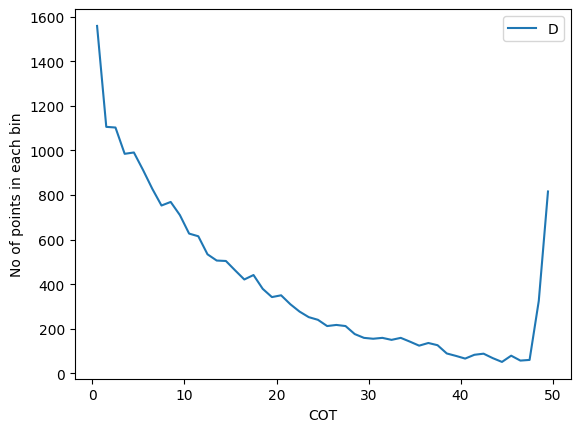

In [ ]:
plt.figure()
plt.plot(x,bin_freq)
plt.legend('Distribution of COT')
plt.ylabel('No of points in each bin')
plt.xlabel('COT')
plt.show()

In [ ]:
A=np.linspace(0,50,21)
print(A)
B=A[:-1]+1.25
print(B)

[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5
 35.  37.5 40.  42.5 45.  47.5 50. ]
[ 1.25  3.75  6.25  8.75 11.25 13.75 16.25 18.75 21.25 23.75 26.25 28.75
 31.25 33.75 36.25 38.75 41.25 43.75 46.25 48.75]
